In [1]:
import math
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import data_catalog
import tseries_mod
import esmlab_wrap

In [2]:
drym = 98288.0 # average dry mass of atmosphere, includes mass above model top [Pa]
P0 = 100000.0 # reference pressure [Pa]
hyai_0 = 0.00225523952394724
tom = hyai_0 * P0 # pressure at top of model
g = 9.80616 # [m/s2]
model_mass_avg = (drym - tom) / g # [kg/m2]
print(model_mass_avg)

10000.089336458437


In [3]:
rearth = 6.37122e6 # [m2]
surf_area = 4.0 * math.pi * rearth ** 2
mwdair = 28.966
kg_to_g = 1.0e3
moles_dair = surf_area * kg_to_g * model_mass_avg / mwdair
mwc = 12.0
vmr_to_PgC = moles_dair * mwc * 1.0e-15
print(vmr_to_PgC)

2113253.840174624


In [4]:
data_catalog.set_catalog('experiments')
varnames = ['TS', 'SFCO2_LND', 'SFCO2_OCN']
experiment = '1pctCO2'
ds_1pctCO2 = tseries_mod.tseries_get_vars(varnames, 'atm', experiment)
ds_1pctCO2_ann = esmlab_wrap.compute_ann_mean(ds_1pctCO2)

active catalog: experiments


In [5]:
# compute change in atmosphere C mass
# co2vmr values are actually end of month instantaneous values
co2vmr_vals = ds_1pctCO2.co2vmr.values
co2vmr_val0 = co2vmr_vals[0] - (co2vmr_vals[1] - co2vmr_vals[0])
co2vmr_edge_vals = np.insert(co2vmr_vals[11::12], 0, co2vmr_val0)
delta_co2_vmr = np.ediff1d(co2vmr_edge_vals)
delta_co2_PgC = vmr_to_PgC * delta_co2_vmr
ds_1pctCO2_ann['delta_CO2'] = xr.DataArray(delta_co2_PgC, dims=('time'), attrs={'units':'Pg yr-1'})

In [6]:
# compute compatible emissions
ds_1pctCO2_ann['CO2_EMIS'] = ds_1pctCO2_ann['delta_CO2'] - ds_1pctCO2_ann['SFCO2_LND'] - ds_1pctCO2_ann['SFCO2_OCN']

In [7]:
# compute cumulative compatible emissions
da = ds_1pctCO2_ann['CO2_EMIS'].cumsum(dim='time')
da.attrs['units'] = 'Pg'
ds_1pctCO2_ann['CO2_EMIS_CUM'] = da

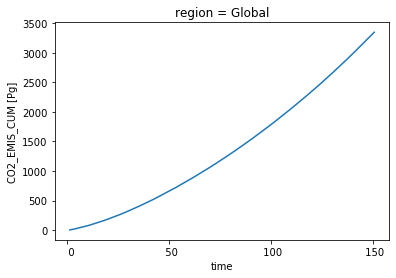

In [8]:
ds_1pctCO2_ann['CO2_EMIS_CUM'].plot();

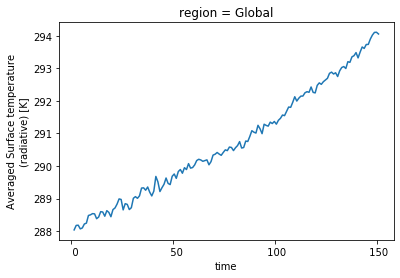

In [9]:
ds_1pctCO2_ann['TS'].plot();

In [10]:
# find when cumulative emissions are 1000
mismatch = np.fabs(ds_1pctCO2_ann['CO2_EMIS_CUM'] - 1000)
min_mismatch = mismatch.where(mismatch == mismatch.min(), drop=True)
init_year = min_mismatch.time.values[0].year + 1
init_year

68